<a href="https://colab.research.google.com/github/Kubenew/ASI/blob/main/Copy_of_HRLVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 750 | Avg reward: 21.55


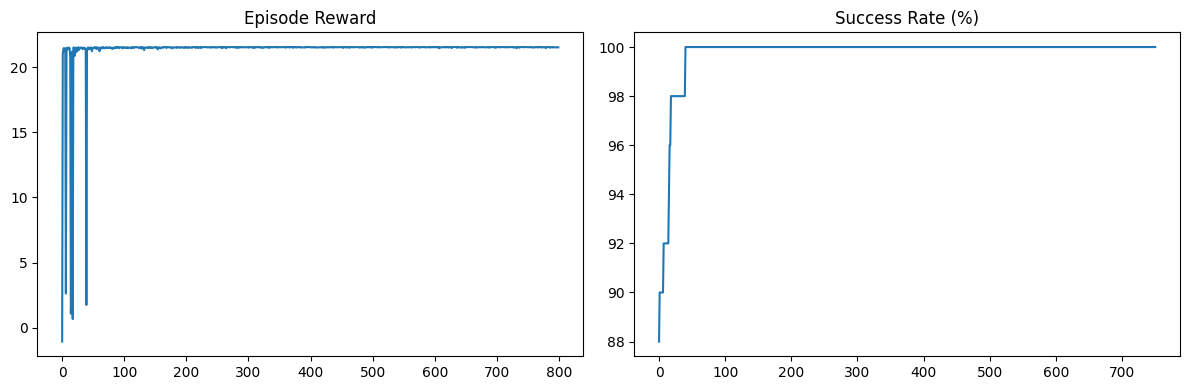

In [ ]:
!pip install numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from matplotlib import animation
from IPython.display import HTML, clear_output
class SimpleMovementEnv:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.max_steps = 100

    def reset(self, goal=(9, 9)):
        self.agent_pos = np.array([0, 0], dtype=float)
        self.goal_pos = np.array(goal, dtype=float)
        self.steps = 0
        return self._state()

    def _state(self):
        return np.concatenate([self.agent_pos, self.goal_pos])

    def step(self, action):
        self.steps += 1

        old_dist = np.linalg.norm(self.agent_pos - self.goal_pos)

        if action == 0: self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        if action == 1: self.agent_pos[0] = min(self.grid_size-1, self.agent_pos[0] + 1)
        if action == 2: self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        if action == 3: self.agent_pos[1] = min(self.grid_size-1, self.agent_pos[1] + 1)

        new_dist = np.linalg.norm(self.agent_pos - self.goal_pos)

        done = False
        reward = old_dist - new_dist - 0.01

        if new_dist < 0.5:
            reward = 10.0
            done = True
        elif self.steps >= self.max_steps:
            reward = -5.0
            done = True

        return self._state(), reward, done, {}
class HierarchicalQLearner:
    def __init__(self):
        self.waypoints = [(2,2), (4,4), (6,6), (8,8), (9,9)]

        self.low_Q  = defaultdict(lambda: np.zeros(4))
        self.high_Q = defaultdict(lambda: np.zeros(len(self.waypoints)))

        self.low_eps  = 0.3
        self.high_eps = 0.4
        self.lr = 0.1
        self.gamma = 0.95

    def discretize(self, pos):
        return tuple(int(round(x)) for x in pos)

    def choose_waypoint(self, state, train=True):
        s = self.discretize(state[:2])
        if train and random.random() < self.high_eps:
            return random.randint(0, len(self.waypoints)-1)
        return np.argmax(self.high_Q[s])

    def choose_action(self, state, wp_idx, train=True):
        s = self.discretize(state)
        wp = self.waypoints[wp_idx]
        key = s + wp
        if train and random.random() < self.low_eps:
            return random.randint(0,3)
        return np.argmax(self.low_Q[key])

    def update_low(self, s, wp_idx, a, r, s2, done):
        key  = self.discretize(s) + self.waypoints[wp_idx]
        key2 = self.discretize(s2) + self.waypoints[wp_idx]
        target = r if done else r + self.gamma*np.max(self.low_Q[key2])
        self.low_Q[key][a] += self.lr*(target - self.low_Q[key][a])

    def update_high(self, s, wp_idx, cumulative_reward, s2):
        k1 = self.discretize(s[:2])
        k2 = self.discretize(s2[:2])
        target = cumulative_reward + self.gamma*np.max(self.high_Q[k2])
        self.high_Q[k1][wp_idx] += self.lr*(target - self.high_Q[k1][wp_idx])

    def decay(self):
        self.low_eps  = max(0.05, self.low_eps * 0.995)
        self.high_eps = max(0.05, self.high_eps * 0.999)
env = SimpleMovementEnv()
agent = HierarchicalQLearner()

episodes = 800
reward_log = []
success_log = []

for ep in range(episodes):
    s = env.reset()
    done = False
    total_reward = 0

    wp_idx = agent.choose_waypoint(s)
    wp_reward = 0
    wp_steps = 0

    while not done:
        a = agent.choose_action(s, wp_idx)
        s2, r, done, _ = env.step(a)

        agent.update_low(s, wp_idx, a, r, s2, done)

        wp_reward += r
        wp_steps += 1

        if np.linalg.norm(s2[:2] - agent.waypoints[wp_idx]) < 1.0:
            agent.update_high(s, wp_idx, wp_reward - wp_steps*0.1, s2)
            wp_reward = 0
            wp_steps = 0
            wp_idx = agent.choose_waypoint(s2)

        s = s2
        total_reward += r

    agent.decay()
    reward_log.append(total_reward)
    success_log.append(1 if total_reward > 5 else 0)

    if ep % 50 == 0:
        clear_output(wait=True)
        print(f"Episode {ep} | Avg reward: {np.mean(reward_log[-50:]):.2f}")
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(reward_log)
plt.title("Episode Reward")

plt.subplot(1,2,2)
ma = np.convolve(success_log, np.ones(50)/50, mode="valid")
plt.plot(ma*100)
plt.title("Success Rate (%)")

plt.tight_layout()
plt.show()
def animate_episode(agent):
    env = SimpleMovementEnv()
    s = env.reset()
    wp = agent.choose_waypoint(s, train=False)

    frames = []
    done = False

    while not done:
        frames.append(env.agent_pos.copy())
        a = agent.choose_action(s, wp, train=False)
        s, _, done, _ = env.step(a)
        if np.linalg.norm(s[:2] - agent.waypoints[wp]) < 1.0:
            wp = min(wp+1, len(agent.waypoints)-1)

    fig, ax = plt.subplots()
    ax.set_xlim(-0.5,9.5)
    ax.set_ylim(-0.5,9.5)
    ax.grid()

    agent_dot, = ax.plot([], [], 'bo', markersize=10)
    goal_dot,  = ax.plot(9,9,'r*',markersize=15)

    def update(i):
        agent_dot.set_data([frames[i][0]], [frames[i][1]]) # Corrected: wrapped in lists and x,y order fixed
        return agent_dot,

    anim = animation.FuncAnimation(fig, update, frames=len(frames), interval=300)
    plt.close()
    return HTML(anim.to_jshtml())

animate_episode(agent)